# Visualization of Electricity Consumption
** Challenge 2 **

by Christoph Stich

March 3, 2016

In [1]:
from sklearn import cluster

import datetime
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline

/home/christoph/anaconda/envs/py34/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Exploring the data

In [2]:
df = pd.read_csv("~/git/EnergyDataSimulationChallenge/challenge2/data/total_watt.csv", header=None, 
                 parse_dates=0, index_col=0, names=['datetime', 'consumption'])
df['date'] = df.index.date
df['time'] = df.index.time
df['weekday'] = df.index.weekday

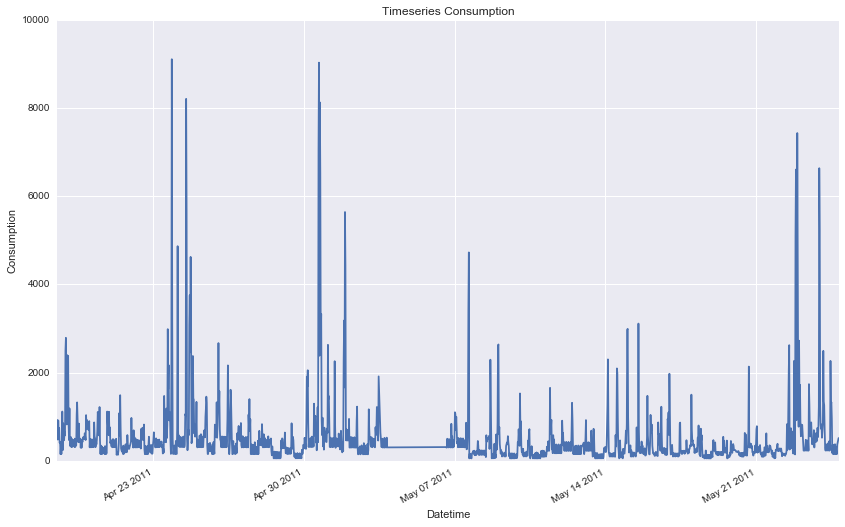

In [3]:
ax = df.plot(figsize=(14, 8.75), y='consumption', legend=False)
plt.title('Timeseries Consumption')
plt.xlabel('Datetime')
plt.ylabel('Consumption')

When looking at the time series of the electricity consumption, one can see that the data is rather 'spiky' and high values are rare. It also looks like that the peaks of the time series are periodic. Furthermore, there is a gap in the data between 10:22PM, May 3, 2011 and 2:22PM, May 6, 2011.

/home/christoph/anaconda/envs/py34/lib/python3.4/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


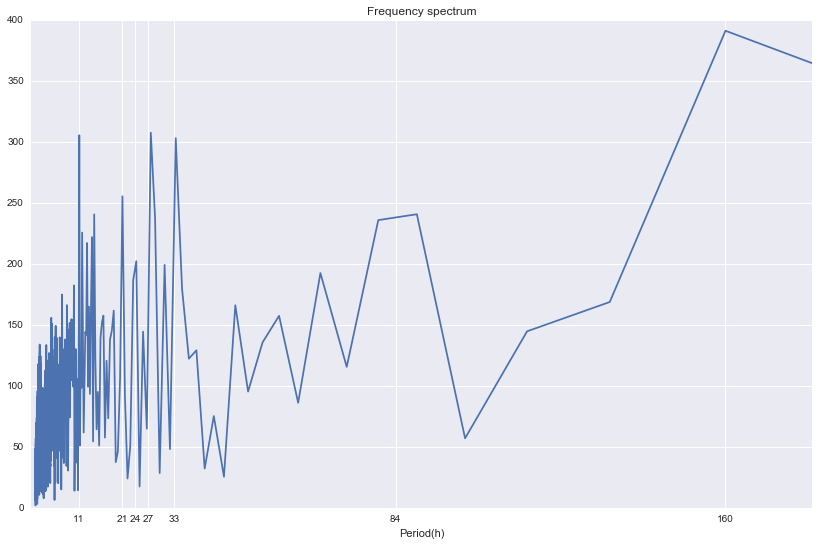

In [4]:
Y = np.fft.fft(df['consumption'])
N = len(Y)/2+1
fa = 1.0/(30.0*60.0) # every 15 minutes
X = np.linspace(0, fa/2, N, endpoint=True)
Xp = 1.0/X 
Xph= Xp/(60.0*60.0) 

fig, ax = plt.subplots(figsize=(14, 8.75))
plt.plot(Xph, 2.0*np.abs(Y[:N])/N)
plt.xticks([11, 21, 24, 27, 33, 84, 160])
plt.title('Frequency spectrum')
plt.xlim(0, 180)
plt.ylim(0, 400)
plt.xlabel('Period(h)')

By applying the fourier transform I can visualize the time series in the frequence domain. The figure shows several peaks that can be interpreted as the "human" rhythm of electricity consumption. The peak at 11 hours can be attributed to the human diurnal rhythm, whereas the peaks at 21, 24, and 27 hours are most likely related to the daily pattern of behavior. The next peak at 33 hours is probably attributable to the diurnal pattern as 33 hours is roughly 1.5 * 24. After that the peaks at 84 and 160 hours represent half-weekly and weekly patterns respectively.

Mean:  509.7891076249156
Standard Deviation:  788.5251741045728


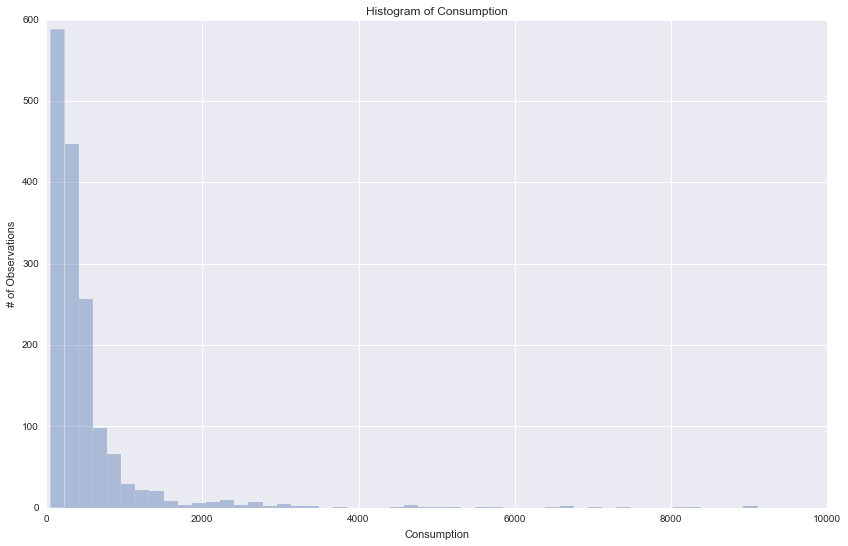

In [5]:
fig, ax = plt.subplots(figsize=(14, 8.75))
sns.distplot(df['consumption'], kde=False)
plt.title('Histogram of Consumption')
plt.xlabel('Consumption')
plt.ylabel('# of Observations')
print('Mean: ', df['consumption'].mean())
print('Standard Deviation: ', df['consumption'].std())

A good starting point is also to look at the distribution of individual observations of consumption. The histogram clearly depicts a heavily skewed distribution. Its mean are ~510 and its standard deviation ~789. The large standard deviation is related to the fact that the tail of the distribution is heavier than one would initially suspect. Arguably the events in the tail are what are most interesting to electricity providers as they have to be able to supply sufficient electricity even during a sudden rise in consumption.

## Daily consumption

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36]), <a list of 37 Text xticklabel objects>)

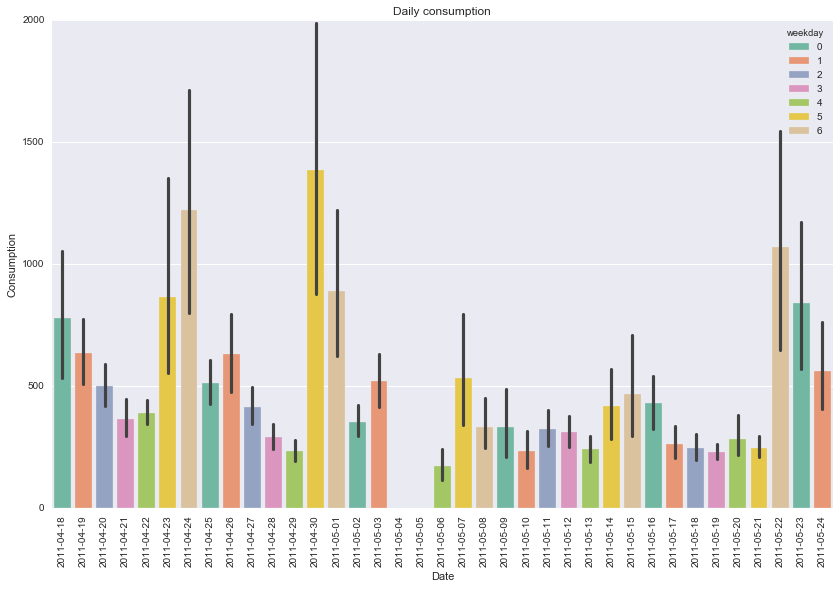

In [6]:
# We want to fix the missing datetime indices before plotting some more things
idx_left = pd.date_range(df.index[0], df.index[-1], freq='1H')
idx_right = pd.date_range(df.index[1], df.index[-1], freq='1H')
idx = [val for pair in zip(idx_left, idx_right) for val in pair]
filled = df.reindex(idx, fill_value=0)
filled['date'] = filled.index.date
filled['time'] = filled.index.time
filled['weekday'] = filled.index.weekday

fig, ax = plt.subplots(figsize=(14, 8.75))
sns.barplot(x='date', y='consumption', data=filled, hue='weekday', palette='Set2', ci=None)
# This is arguably a bit hacky but still faster than estimating the CI by hand and plotting everything with plt.bar
palette = itertools.cycle(sns.color_palette("Set2", 7))
sns.barplot(x='date', y='consumption', palette=palette, data=filled, ci=95)
plt.title('Daily consumption')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.xticks(rotation='vertical')

The plot shows the aggregated daily consumption with bootstrapped confidence intervalls of 95%. The week starts on a Monday ("0"). Most of all days of a high consumption fall on a weekend. The confidence interval for days with high consumption are relatively large as well, indicating a relatively large variation in measured values. For the other days the confidence intervals are consequentially smaller.

## Aggregated half-hourly consumption

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
 <a list of 48 Text xticklabel objects>)

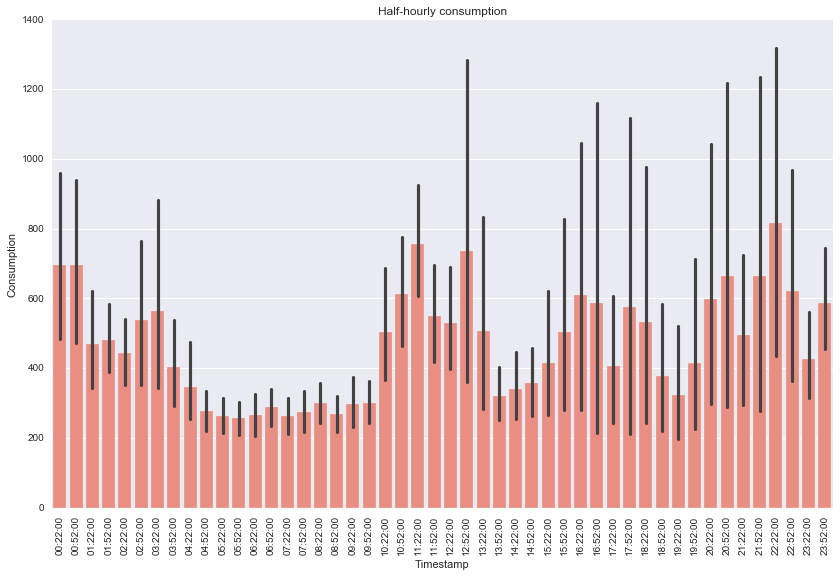

In [7]:
fig, ax = plt.subplots(figsize=(14, 8.75))
order = list(sorted(set(df['time'].values)))
sns.barplot(x='time', y='consumption', color='salmon', order=order, data=filled, ci=95)
plt.title('Half-hourly consumption')
plt.xlabel('Timestamp')
plt.ylabel('Consumption')
plt.xticks(rotation='vertical')

I generate this figure by aggregating all observations at each half-hour timeslot. The figure reveals a relatively stable period of low consumption between 4:52 and 9:52. There is also a slight peak around noon, which is probably related to cookin. After that the average consumption varies before it peaks again in the evening.

## Heatmap

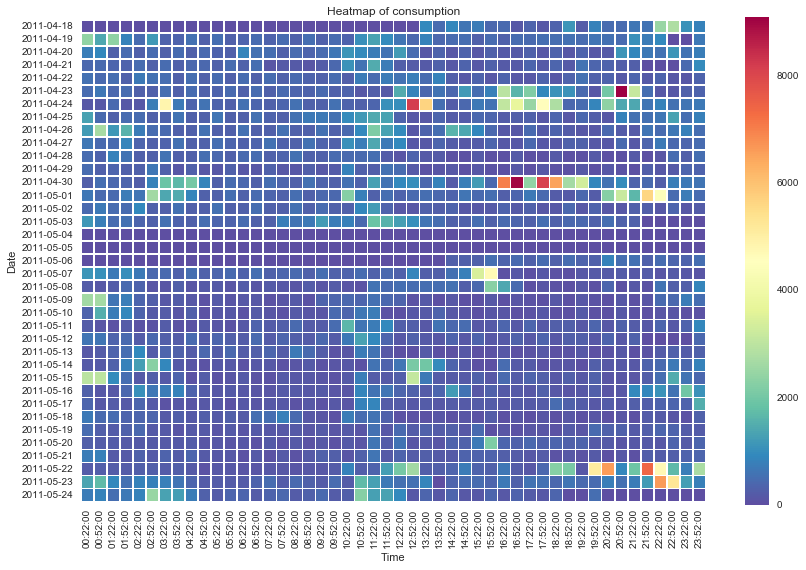

In [8]:
m = filled.pivot(index='date', columns='time', values='consumption')
m = m.fillna(0.0)

fig, ax = plt.subplots(figsize=(14, 8.75))
yticks = sorted(set(str(label)[:10] for label in filled.index.values))
ax = sns.heatmap(m, square=True, cmap='Spectral_r', linewidths=.5, yticklabels=yticks)
plt.title('Heatmap of consumption')
plt.xlabel('Time')
plt.ylabel('Date')

In this figure rows represent days, columns represent time, and the color value depicts the magnitude of the observation. This figure reveals that high values are spatially clustered in the time as well as the day dimension. In other words, high values occur during the evening on weekends (including Friday evening). It would be quite an interesting problem to figure out if we could predict those high values reliably. 

## Clustering
I chose to use k-means for clustering the measurements into a low, medium, and high cluster of power consumption for two reasons: a) k-means only needs one paramter---k, the number of clusters---and this is already given and b) while the euclidean distance the algorithm is based on is ill-behaved in high dimensions ("curse of dimensionality"), we use only one dimension ("power consumption") for clustering. 

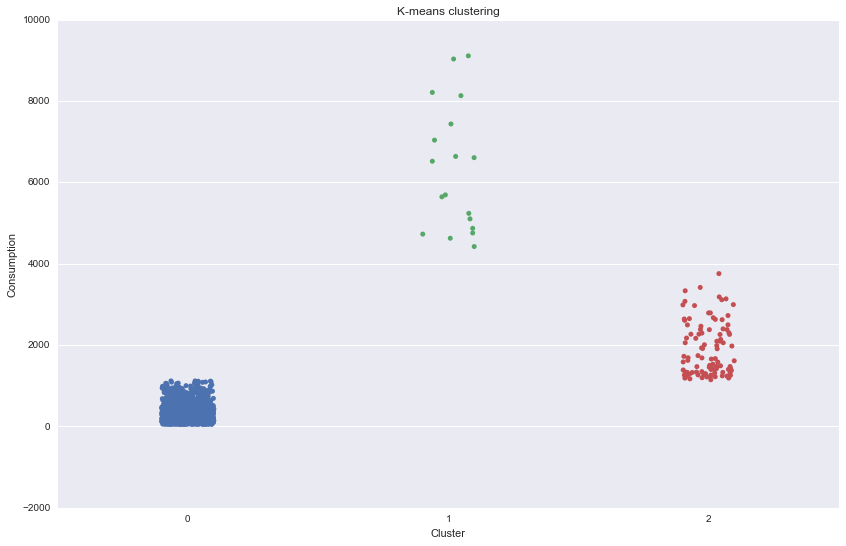

In [9]:
kmeans = cluster.KMeans(n_clusters=3, n_init=500)
kmeans.fit(np.asarray(df['consumption']).reshape(-1, 1))
df['cluster'] = kmeans.labels_

fig, ax = plt.subplots(figsize=(14, 8.75))
sns.stripplot(y='consumption', x='cluster', data=df, jitter=True)
plt.title('K-means clustering')
plt.xlabel('Cluster')
plt.ylabel('Consumption')

The figure shows the three clusters of low, medium, and high power consumption. The low cluster is the most dense and also has the most observations. The medium cluster has fewer observations and more variance than the lower cluster. Last but not least the high cluster

## What to do next?
1. Analyse the periodicity of the time series in more detail. Potentially build an AR, MA, or ARMA model.
2. Build a machine learning model that is able to predict peaks in the power consumption. Potentially gather more data for this.